In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to simulate CIR model
def cir_simulation(params, initial_rate, time_step, num_steps, num_paths):
    kappa, theta, sigma = params
    dW = np.random.normal(0, np.sqrt(time_step), (num_steps, num_paths))
    rates = np.zeros((num_steps + 1, num_paths))
    rates[0, :] = initial_rate
    for t in range(num_steps):
        rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * np.sqrt(np.maximum(rates[t, :], 0)) * dW[t, :]
    return rates

#np.maximum(rates[t, :], 0) to ensure that the square root is taken only of non-negative values, preventing negative rates.

# Calibration function for CIR model
def cir_calibration(params, data, time_step, num_steps):
    initial_rate = data.iloc[0]
    simulated_rates = cir_simulation(params, initial_rate, time_step, num_steps, num_paths=1)
    return np.sum((simulated_rates[:, 0] - data) ** 2)

In [13]:
# Load combined data
combined_data = pd.read_csv('/Users/atifzeya/Documents/interest_rate_models/interest_rate_data.csv', index_col='Date', parse_dates=True)/100
original_2023_data_cir = combined_data.loc['2023-01-01':'2023-12-31']
original_2023_data_cir


,3-Month,5-Year,10-Year,30-Year
Date,,,,
2023-01-03,0.04255,0.03945,0.03793,0.03893
2023-01-04,0.04400,0.03875,0.03709,0.03820
2023-01-05,0.04498,0.03910,0.03720,0.03798
2023-01-06,0.04493,0.03712,0.03569,0.03692
2023-01-09,0.04483,0.03651,0.03517,0.03650
...,...,...,...,...
2023-10-25,0.05315,0.04918,0.04953,0.05092
2023-10-26,0.05300,0.04797,0.04845,0.04988
2023-10-27,0.05305,0.04770,0.04845,0.05023


In [15]:
# Set time step and number of steps for simulation
time_step = 1
num_steps = len(combined_data.loc['2000-01-01':'2022-12-31']) - 1 #as we are using 2000 to 2022 for calibration

# Initial guess for parameters
initial_guess_cir = [0.05, 0.05, 0.05] #kappa, theta, sigma

# Set a seed for reproducibility
seed = 50  # We can choose any integer


In [31]:
# Calibrate using historical data from 2000 to 2022 for each tenor
calibrated_params_cir = {
    tenor: minimize(cir_calibration, initial_guess_cir, args=(combined_data[tenor].loc['2000-01-01':'2022-12-31'], time_step, num_steps)).x
    for tenor in combined_data.columns
}


/var/folders/s7/990_974x3m50ysnp8tcvdts00000gn/T/ipykernel_3514/2696137762.py:13: RuntimeWarning: overflow encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * np.sqrt(np.maximum(rates[t, :], 0)) * dW[t, :]
/var/folders/s7/990_974x3m50ysnp8tcvdts00000gn/T/ipykernel_3514/2696137762.py:13: RuntimeWarning: invalid value encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * np.sqrt(np.maximum(rates[t, :], 0)) * dW[t, :]
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/s7/990_974x3m50ysnp8tcvdts00000gn/T/ipykernel_3514/2696137762.py:13: RuntimeWarning: overflow encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * np.sqrt(np.maximum(rates[t, :], 0)) * dW[t, :]
/var/folders/s7/990_974x3m50ysnp8tcvdts00000gn/T/ipykernel_3514/26961

In [21]:
# Monte Carlo simulation for 2023
num_paths_cir = 5000
simulation_results_cir = {
    tenor: cir_simulation(params, combined_data[tenor].iloc[-1], time_step, len(original_2023_data_cir)-1, num_paths_cir)
    for tenor, params in calibrated_params_cir.items()
}
simulation_results_cir

{'3-Month': array([[0.0532    , 0.0532    , 0.0532    , ..., 0.0532    , 0.0532    ,
         0.0532    ],
        [0.07054923, 0.07073964, 0.02976469, ..., 0.06510194, 0.03203254,
         0.05385778],
        [0.07523932, 0.06464332, 0.02043195, ..., 0.04461602, 0.02158311,
         0.05176418],
        ...,
        [0.0180692 , 0.01387762, 0.04236928, ..., 0.10578858, 0.04611375,
         0.02588586],
        [0.01913957, 0.01676459, 0.02455754, ..., 0.09512171, 0.0632937 ,
         0.02239363],
        [0.0192131 , 0.02188811, 0.02341129, ..., 0.09770645, 0.08648879,
         0.02007528]]),
 '5-Year': array([[0.04816   , 0.04816   , 0.04816   , ..., 0.04816   , 0.04816   ,
         0.04816   ],
        [0.03795347, 0.05006253, 0.05821244, ..., 0.0418983 , 0.0330111 ,
         0.04143055],
        [0.02530255, 0.0575633 , 0.0624504 , ..., 0.03607544, 0.03265898,
         0.03612693],
        ...,
        [0.09998908, 0.02503366, 0.05494326, ..., 0.00717578, 0.01486775,
         0.02

In [25]:
# Create DataFrame with original 2023 data and forecasted data
original_2023_data_cir = combined_data.loc['2023-01-01':'2023-12-31']
forecasted_2023_data_cir = pd.DataFrame({tenor: np.mean(paths, axis=1) for tenor, paths in simulation_results_cir.items()}, index=original_2023_data_cir.index)

# Calculate the difference between original and forecasted data
difference_data_cir = original_2023_data_cir - forecasted_2023_data_cir

# Calculate the standard deviation of differences
std_dev_difference = difference_data_cir.std()

# Calculate the root mean squared error (RMSE)
rmse_per_tenor = np.sqrt(np.mean(difference_data_cir**2,axis=0))
rmse_per_tenor

3-Month    0.003448
5-Year     0.010489
10-Year    0.011553
30-Year    0.010470
dtype: float64

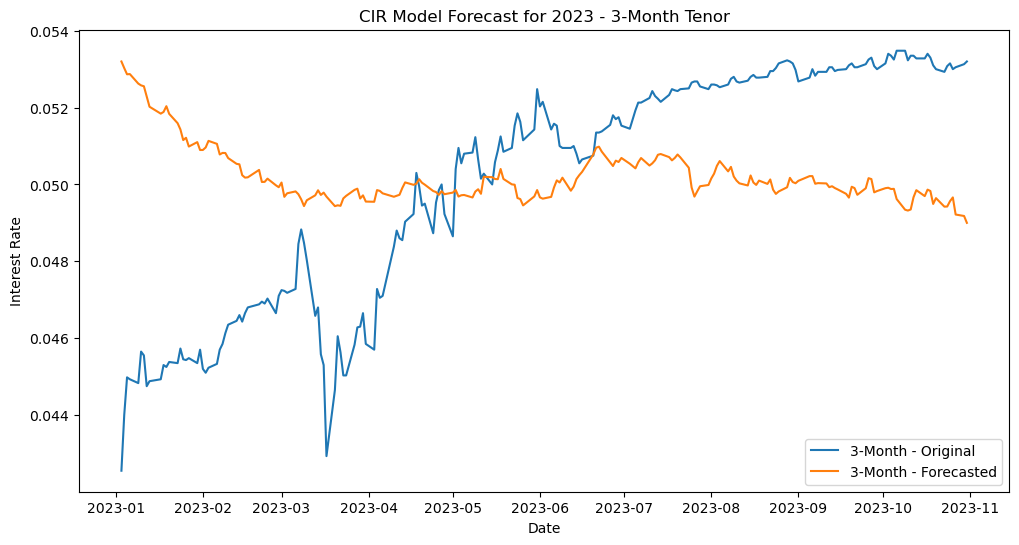

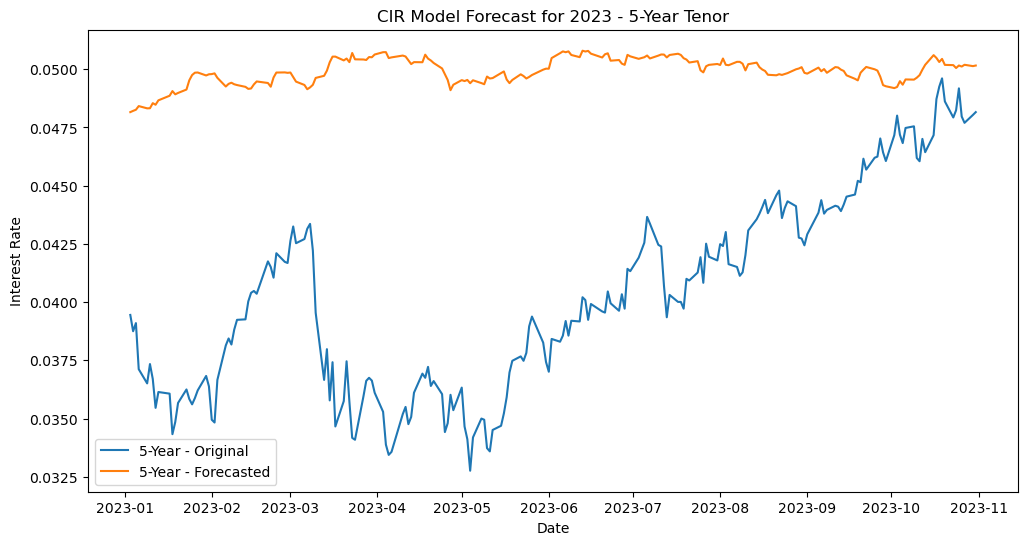

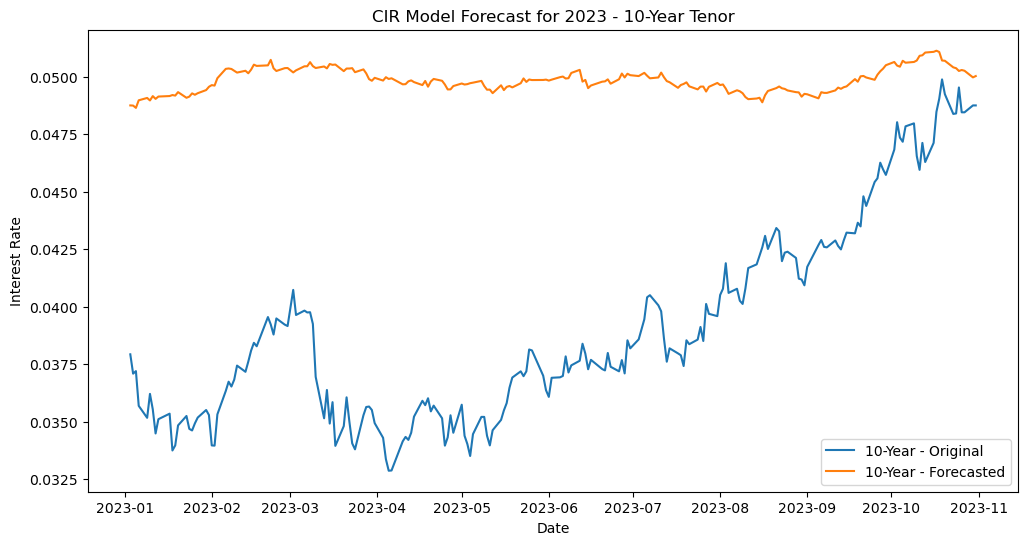

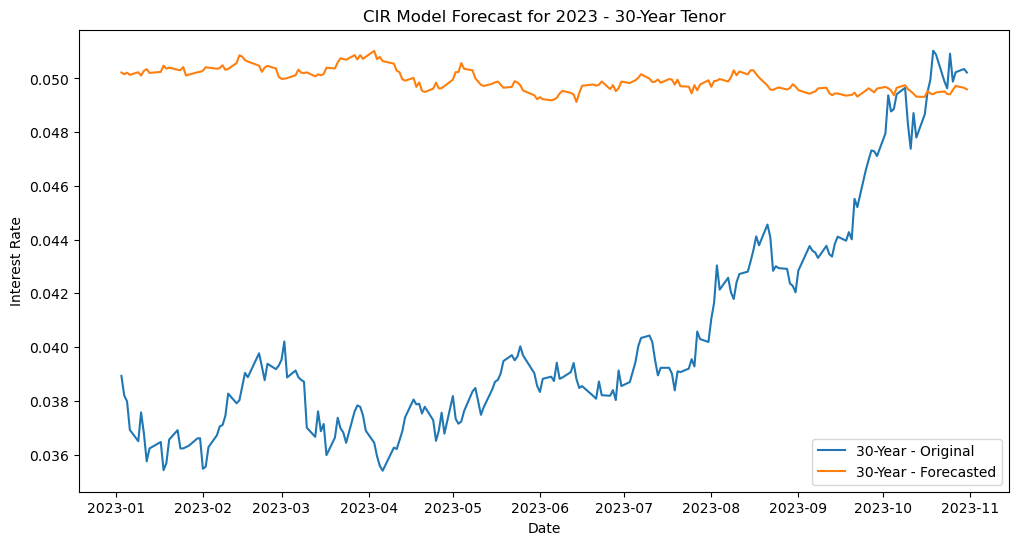

In [27]:
# Visualize the results for each tenor
for tenor in combined_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(original_2023_data_cir.index, original_2023_data_cir[tenor], label=f"{tenor} - Original")
    plt.plot(original_2023_data_cir.index, forecasted_2023_data_cir[tenor], label=f"{tenor} - Forecasted")
    plt.title(f"CIR Model Forecast for 2023 - {tenor} Tenor")
    plt.xlabel("Date")
    plt.ylabel("Interest Rate")
    plt.legend()
    plt.show()


In [29]:

# Display the DataFrames for CIR model
print("Original 2023 Data (CIR):")
print(original_2023_data_cir)
print("\nForecasted 2023 Data (CIR):")
print(forecasted_2023_data_cir)
print("\nDifference between Original and Forecasted Data (CIR):")
print(difference_data_cir)
print("\nMean Difference between Original and Forecasted Data (CIR):")
print(difference_data_cir.mean())
print("Standard Deviation of Differences:")
print(std_dev_difference)
print("Root Mean Squared Error (RMSE) for Each Tenor:")
print(rmse_per_tenor)
print(calibrated_params_cir)


Original 2023 Data (CIR):
            3-Month   5-Year  10-Year  30-Year
Date                                          
2023-01-03  0.04255  0.03945  0.03793  0.03893
2023-01-04  0.04400  0.03875  0.03709  0.03820
2023-01-05  0.04498  0.03910  0.03720  0.03798
2023-01-06  0.04493  0.03712  0.03569  0.03692
2023-01-09  0.04483  0.03651  0.03517  0.03650
...             ...      ...      ...      ...
2023-10-25  0.05315  0.04918  0.04953  0.05092
2023-10-26  0.05300  0.04797  0.04845  0.04988
2023-10-27  0.05305  0.04770  0.04845  0.05023
2023-10-30  0.05313  0.04804  0.04875  0.05035
2023-10-31  0.05320  0.04816  0.04875  0.05022

[209 rows x 4 columns]

Forecasted 2023 Data (CIR):
             3-Month    5-Year   10-Year   30-Year
Date                                              
2023-01-03  0.053200  0.048160  0.048750  0.050220
2023-01-04  0.053028  0.048214  0.048743  0.050155
2023-01-05  0.052867  0.048262  0.048643  0.050212
2023-01-06  0.052872  0.048419  0.048972  0.050131
2023